#### Data Dictionary
- `regio1`: Bundesland 
- `serviceCharge`: Auxiliary costs such as electricty or internet [Euro]
- `heatingType`: Type of heating
- `telekomTvOffer`: Is payed TV included? If so, which offer?
- `telekomHybridUploadSpeed`: How fast is the hybrid inter upload speed?
- `newlyConst`: Is the building newly constructed?
- `balcony`: Does the object have a balcony?
- `picturecount`: How many pictures were uploaded to the listing?
- `pricetrend`: Price trend as calculated by Immoscout
- `telekomUploadSpeed`: How fast is the internet upload speed?
- `totalRent`: Total rent (usually a sum of base rent, service charge and heating cost)
- `yearConstructed`: Construction year
- `scoutId`: Immoscout Id
- `noParkSpaces`: Number of parking spaces
- `firingTypes`: Main energy sources, separated by colon
- `hasKitchen`: Has a kitchen
- `geo_bln`: Same as regio1
- `cellar`: Has a cellar
- `yearConstructedRange`: Binned construction year, 1 to 9
- `baseRent`: Base rent without electricity and heating
- `houseNumber`: House number
- `livingSpace`: Living space in sqm
- `geo_krs`: District, above ZIP code
- `condition`: Condition of the flat
- `interiorQual`: Interior quality
- `petsAllowed`: Are pets allowed, can be yes, no or negotiable
- `street`: Street name
- `streetPlain`: Street name (plain, different formating)
- `lift`: Is elevator available
- `baseRentRange`: Binned base rent, 1 to 9
- `typeOfFlat`: Type of flat
- `geo_plz`: ZIP code
- `noRooms`: Number of rooms
- `thermalChar`: Energy need in kWh/(m^2a), defines the energy efficiency class
- `floor`: Which floor is the flat on
- `numberOfFloors`: Number of floors in the building
- `noRoomsRange`: Binned number of rooms, 1 to 5
- `garden`: Has a garden
- `livingSpaceRange`: Binned living space, 1 to 7
- `regio2`: District or Kreis, same as geo krs
- `regio3`: City/town
- `description`: Free text description of the object
- `facilities`: Free text description about available facilities
- `heatingCosts`: Monthly heating costs in [Euro]
- `energyEfficiencyClass`: Energy efficiency class (based on binned thermalChar, deprecated since Feb 2020)
- `lastRefurbish`: Year of last renovation
- `electricityBasePrice`: Monthly base price for electricity in € (deprecated since Feb 2020)
- `electricityKwhPrice`: Electricity price per kwh (deprecated since Feb 2020)
- `date`: Time of scraping

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np 

from analysis_src.basic_data_inspection import DataInspector, DataTypesInspectionStrategy, SummaryStatisticsInspectionStrategy
from analysis_src.missing_values_analysis import SimpleMissingValuesAnalysis
from analysis_src.univariate_analysis import UnivariateAnalyzer, NumericalUnivariateAnalysis, CategoricalUnivariateAnalysis
from analysis_src.bivariate_analysis import BivariateAnalyzer, NumericalVsNumericalAnalysis, CategoricalVsNumericalAnalysis
from analysis_src.multivariate_analysis import SimpleMultivariateAnalysis

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
data_path = "../data/extracted/immo_data.csv"
df = pd.read_csv(data_path)

## Insights about Dataset

#### **1. Data Types and Non-null Counts:**
- The dataset contains **268850 entries** and **49 columns**.
- **Data Types:** There are 18 columns with `float64` data type, 6 columns with `int64` data type, 6 columns with `bool`data type and 19 columns with `object` data type.
    - **Numerical Columns**: These include features like `scoutid`, `serviceCharge`, `totalRent` and `picturecount`.
    - **Categorical Columns**: These include features like `regio1`, `heatingType`, `regio2`, `telekomTvOffer`, `firingTypes`, etc. Note that many of these categorical features have either `object` or `bool` data types.

#### **2. Summary Statistics:**
- **Numerical Features**:
    - `serviceCharge` ranges from **~0 to 14,6118** with a mean of **151.20**, indicating that the dataset includes entries which could potentially be outliers and need to be managed before model building.
    - Similarly, the target variable `totalRent` has a wide range of **~0 to ~15,751,540** with a mean and standard deviation of **~901** and **~33,238** respectively. This also indicates existence of outliers.
    - Similarly, `yearConstructed` has a wide distribution range of **year 1000 to year 2090** with a mean of **1960**. Further analysis is needed to check correctness of entries as the year of construction cannot be in the future

- **Categorical Features**:
    - `regio1`, `regio2` and `regio3` has multiple unique entries about the location of the accommodation with regio1 showing the state, regio2 showing the distric/kreis and regio3 showing the city/town. **Nordrhein_Westfalen has most number of entries**.
    - Multiple categorical features like `heatingType`, `firingType`, and `condition` have important information about the accommodation and should be further analysed and cleaned before being used for modeling.
    - There are many features like **`houseNumber`, `geo_bln`, `description`, `street`, `streetPlain` and `data`** which are not important for modeling and can be removed.

#### **3. Missing Values Analysis:**
- Multiple features have missing values and features like `electricityKwhPrice`, `electricityBasePrice` and `telekomHybridUploadSpeed` have **>80% missing values**.
- Features with **missing data requires imputation or handling/deletion**. While imputation can be valuable for features with some missing values, feature deletion might be required for those with higher frequency of missing values. **Used >30% missing value threshold for deletion**.



In [4]:
df.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [5]:
# Step 1: Basic Data Inspection

data_inspector = DataInspector(DataTypesInspectionStrategy())
data_inspector.execute_inspection(df)


Data Types and Non-null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpace

In [6]:
# Switch strategy to Summary Statistics Inspection

data_inspector.set_strategy(SummaryStatisticsInspectionStrategy())
data_inspector.execute_inspection(df)


Summary Statistics (Numerical Features):
       serviceCharge  telekomHybridUploadSpeed   picturecount     pricetrend  \
count  261941.000000                   45020.0  268850.000000  267018.000000   
mean      151.206113                      10.0       9.791958       3.389001   
std       308.295790                       0.0       6.408399       1.964874   
min         0.000000                      10.0       0.000000     -12.330000   
25%        95.000000                      10.0       6.000000       2.000000   
50%       135.000000                      10.0       9.000000       3.390000   
75%       190.000000                      10.0      13.000000       4.570000   
max    146118.000000                      10.0     121.000000      14.920000   

       telekomUploadSpeed     totalRent  yearConstructed       scoutId  \
count       235492.000000  2.283330e+05    211805.000000  2.688500e+05   
mean            28.804928  9.013315e+02      1966.400590  1.069697e+08   
std            

In [7]:
missing_values_percentage = df.isnull().sum()*100/df.shape[0]
missing_values_percentage

regio1                       0.000000
serviceCharge                2.569834
heatingType                 16.684397
telekomTvOffer              12.132788
telekomHybridUploadSpeed    83.254603
newlyConst                   0.000000
balcony                      0.000000
picturecount                 0.000000
pricetrend                   0.681421
telekomUploadSpeed          12.407662
totalRent                   15.070485
yearConstructed             21.218151
scoutId                      0.000000
noParkSpaces                65.388879
firingTypes                 21.188023
hasKitchen                   0.000000
geo_bln                      0.000000
cellar                       0.000000
yearConstructedRange        21.218151
baseRent                     0.000000
houseNumber                 26.415473
livingSpace                  0.000000
geo_krs                      0.000000
condition                   25.474800
interiorQual                41.906267
petsAllowed                 42.615957
street      


Missing Values Percentage by Column:
regio1                       0.00
serviceCharge                2.57
heatingType                 16.68
telekomTvOffer              12.13
telekomHybridUploadSpeed    83.25
newlyConst                   0.00
balcony                      0.00
picturecount                 0.00
pricetrend                   0.68
telekomUploadSpeed          12.41
totalRent                   15.07
yearConstructed             21.22
scoutId                      0.00
noParkSpaces                65.39
firingTypes                 21.19
hasKitchen                   0.00
geo_bln                      0.00
cellar                       0.00
yearConstructedRange        21.22
baseRent                     0.00
houseNumber                 26.42
livingSpace                  0.00
geo_krs                      0.00
condition                   25.47
interiorQual                41.91
petsAllowed                 42.62
street                       0.00
streetPlain                 26.41
lift      

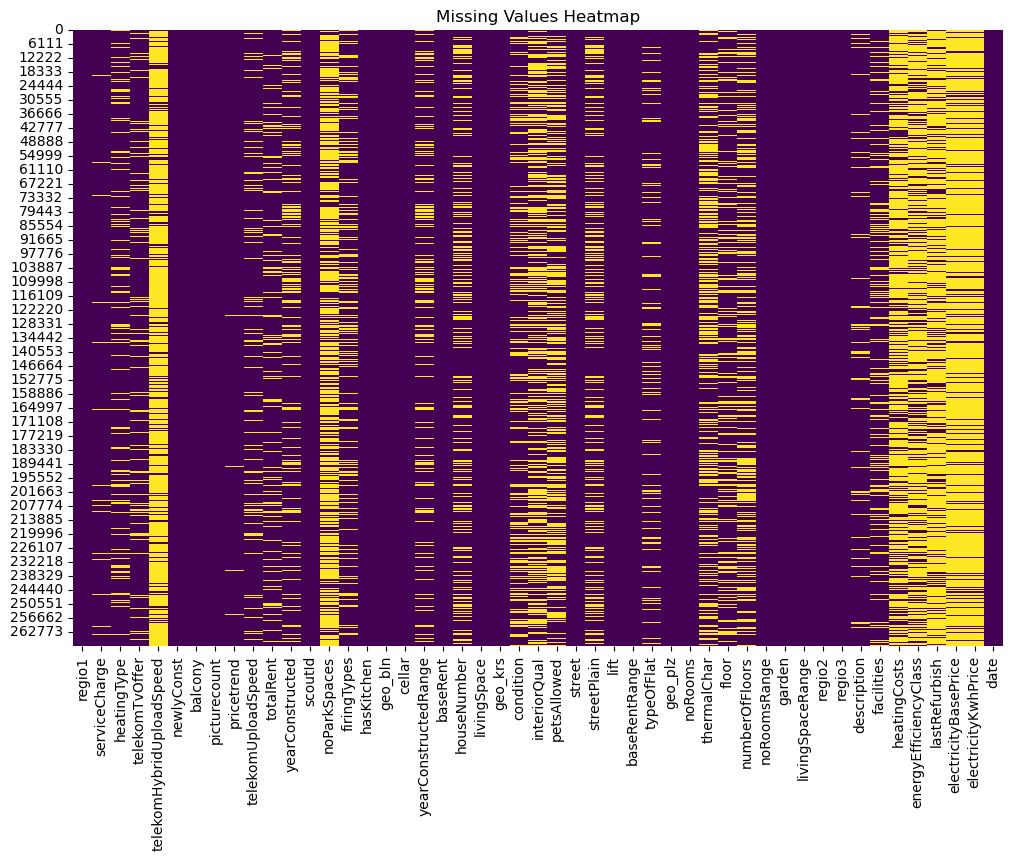

In [8]:
# Step 2: Missing Values Analysis

missing_values_analyzer = SimpleMissingValuesAnalysis()
missing_values_analyzer.analyze(df)

In [ ]:
# Step 3: Handling missing values and unimportant features

# Removing the columns that have more than 30% missing values
df_filtered = df.dropna(axis=1, thresh=0.7 * df.shape[0])

# Removing the columns that are less relevant for rent prediction
df_filtered = df_filtered.drop(columns=['livingSpaceRange','street','description','facilities',
    'geo_krs','geo_plz','scoutId','regio1','telekomUploadSpeed','telekomTvOffer','pricetrend',
    'houseNumber','streetPlain','regio3','noRoomsRange','picturecount','geo_bln','date'])

df_filtered.head(5)

,serviceCharge,heatingType,newlyConst,balcony,totalRent,yearConstructed,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,condition,lift,baseRentRange,typeOfFlat,noRooms,floor,garden,regio2
0,245.00,central_heating,False,False,840.0,1965.0,oil,False,True,2.0,595.0,86.00,well_kept,False,4,ground_floor,4.0,1.0,True,Dortmund
1,134.00,self_contained_central_heating,False,True,NaN,1871.0,gas,False,False,1.0,800.0,89.00,refurbished,False,5,ground_floor,3.0,NaN,False,Rhein_Pfalz_Kreis
2,255.00,floor_heating,True,True,1300.0,2019.0,NaN,False,True,9.0,965.0,83.80,first_time_use,True,6,apartment,3.0,3.0,False,Dresden
3,58.15,district_heating,False,True,NaN,1964.0,district_heating,False,False,2.0,343.0,58.15,NaN,False,2,other,3.0,3.0,False,Mittelsachsen_Kreis
4,138.00,self_contained_central_heating,False,True,903.0,1950.0,gas,False,False,1.0,765.0,84.97,refurbished,False,5,apartment,3.0,1.0,False,Bremen


## Insights from Univariate and Bivariate Analysis

#### **1. Univariate Analysis:**
- **Condition Distribution:**
    - The condition column shows **significant class imbalance**.
    - Minority classes like `negotiable`, `need_of_renovation` and `ripe_for_demolition` can be combined into one class (e.g., others).
- **TypeOfFlat Distribution:**
    - Most accommodation are of the type **apartment**, however, significant number of other types are present in the dataset.
- **yearConstructed Distribution:**
    - Most accommodations are built **between year 1900 and present**, however, the dataset has entries as yearly as year 1000 and entries way ahead in the future.
    - Incorrect entries and those that are identified as outliers should be removed before data modeling.
- **livingSpace Distribution:**
    - `livingSpace` has a wide distribution with a **mean and standard deviation of ~74 and ~255, respectively**.
    - Distribution curve shows a **skew towards very large living space** with a maximum entry of ~111111.
    - Entries that identified as outliers should be removed before data modeling.
- **newlyConst Status Distribution:**
    - Significantly higher proportion of entries which are **not newly constructed**.
- **balcony Status Distribution:**
    - Higher proportion of entries which **have balcony**.

#### **2. Bivariate Analysis:**
- **livingSpace vs. totalRent (Numerical vs. Numerical):**
    - Entries with **higher living space** are more likely to have **higher total rent**.
    - However, the **positive correlation is weak** indicating the importance of other features like location, condition, type of accommodation.
- **Service Charge vs. Total Rent (Numerical vs. Numerical):**
    - Preliminary analysis suggest a **positive corelation between Service Charge and Total Rent**.
- **Condition vs. Total Rent (Categorical vs. Numerical):**
    - Good conditioned accommodations with classes like `mint_condition` and `first_time_use` have a **higher mean total rent** compared to other classes
    - Most condition types have **multiple outliers in terms of total rent**.


/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/univariate_analysis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


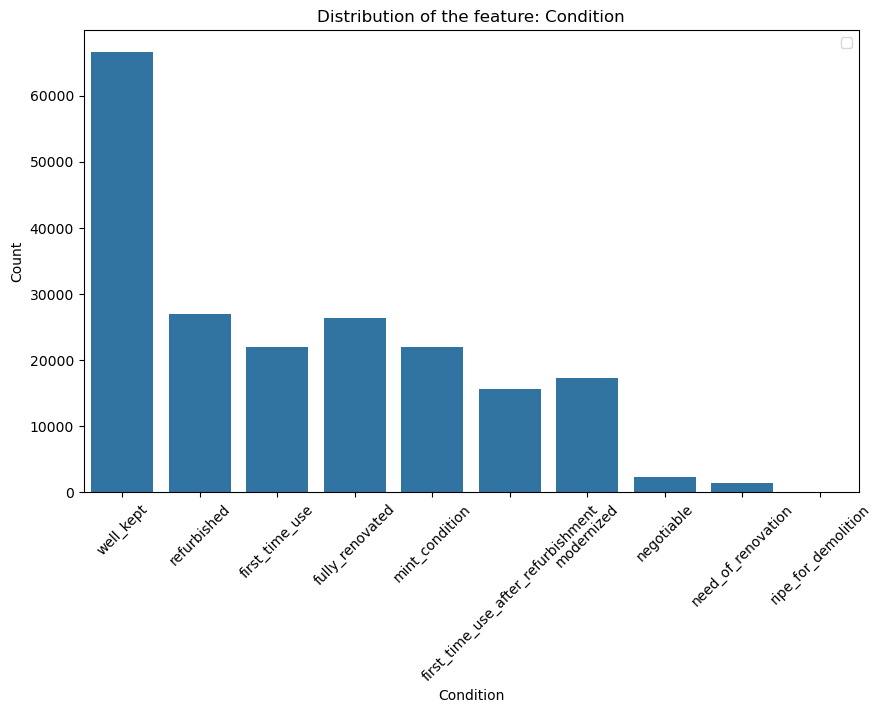

In [ ]:
# Step 4: Univariate Analysis

# Analyzing Target Feature "condition"
univariate_analyzer = UnivariateAnalyzer(CategoricalUnivariateAnalysis())
univariate_analyzer.execute_analysis(df_filtered, "condition")

/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/univariate_analysis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


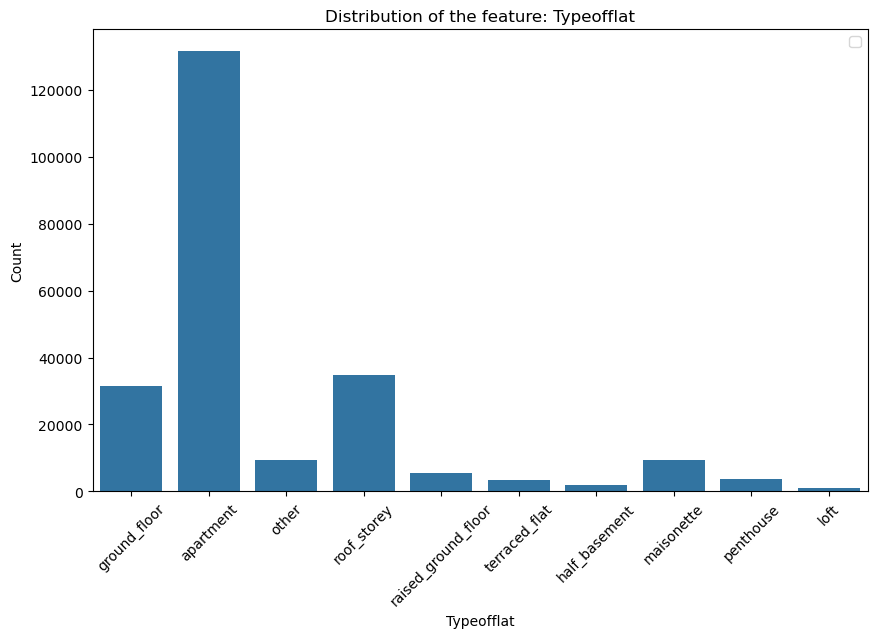

In [11]:
# Analyzing Target Feature "typeOfFlat"
univariate_analyzer = UnivariateAnalyzer(CategoricalUnivariateAnalysis())
univariate_analyzer.execute_analysis(df_filtered, "typeOfFlat")

/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/univariate_analysis.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


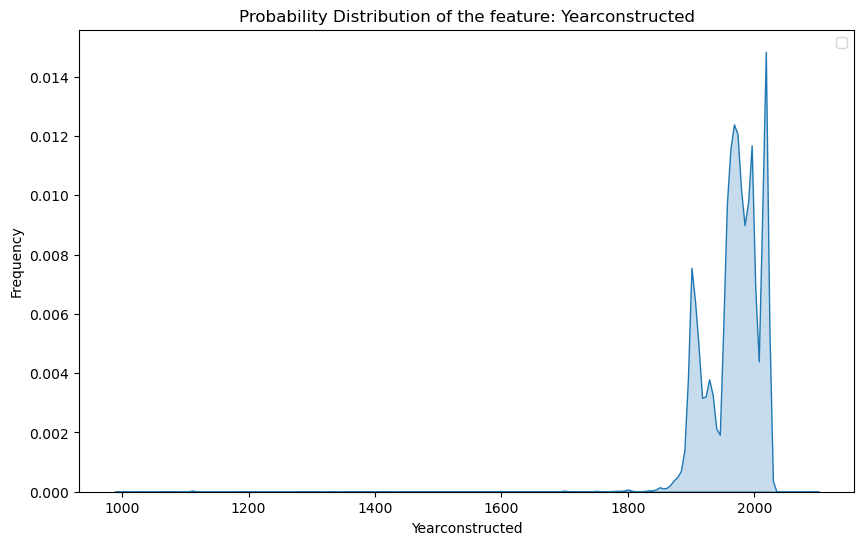

In [12]:
# Analyzing Numerical Feature "yearConstructed"
univariate_analyzer = UnivariateAnalyzer(NumericalUnivariateAnalysis())
univariate_analyzer.execute_analysis(df_filtered, "yearConstructed")

/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/univariate_analysis.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


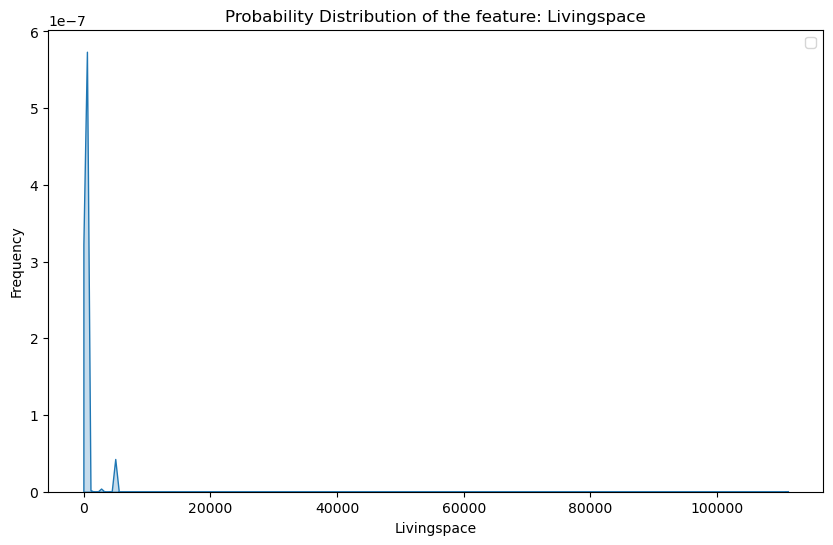

In [13]:
# Analyzing Numerical Feature "livingSpace"
univariate_analyzer = UnivariateAnalyzer(NumericalUnivariateAnalysis())
univariate_analyzer.execute_analysis(df_filtered, "livingSpace")

/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/univariate_analysis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


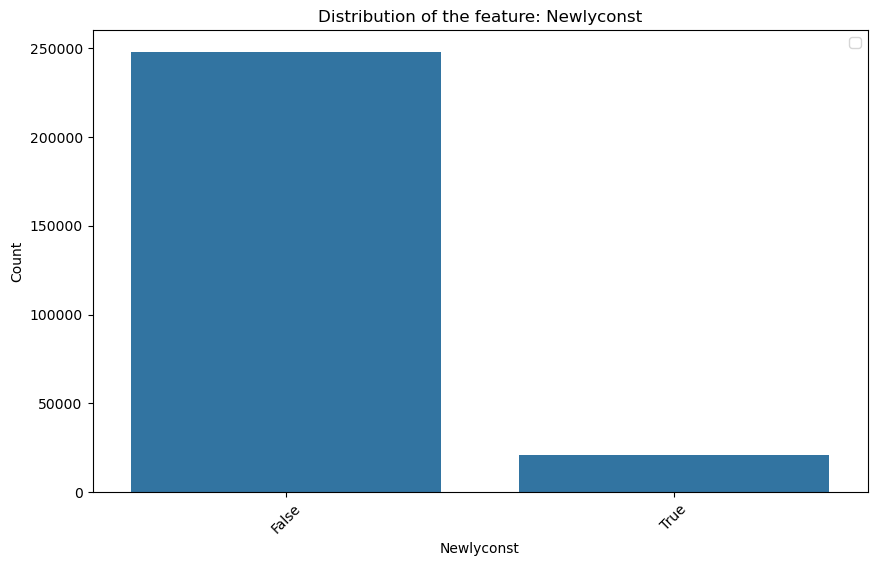

In [14]:
# Analyzing Categorical Feature "newlyConst"
univariate_analyzer.set_strategy(CategoricalUnivariateAnalysis())
univariate_analyzer.execute_analysis(df_filtered, "newlyConst")

/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/univariate_analysis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


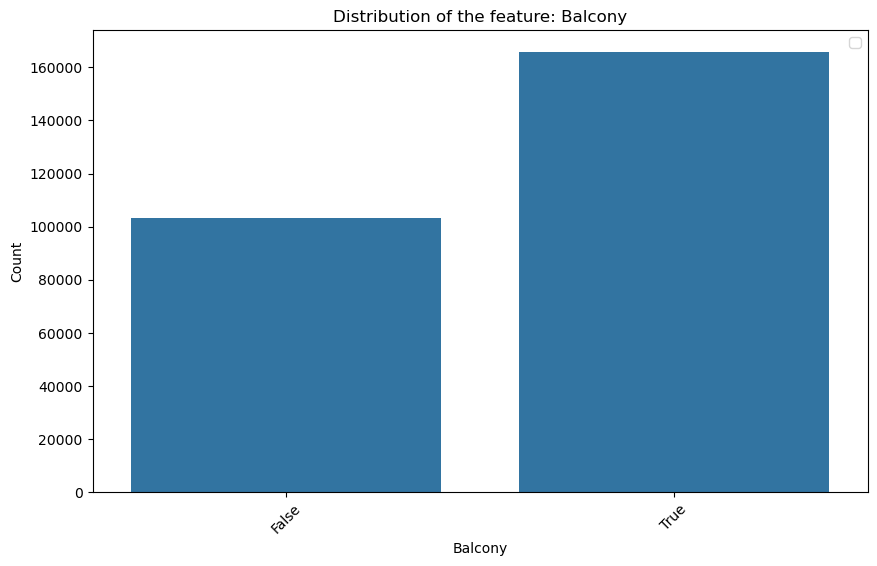

In [15]:
# Analyzing Categorical Feature "balcony"
univariate_analyzer.execute_analysis(df, "balcony")

/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/bivariate_analysis.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


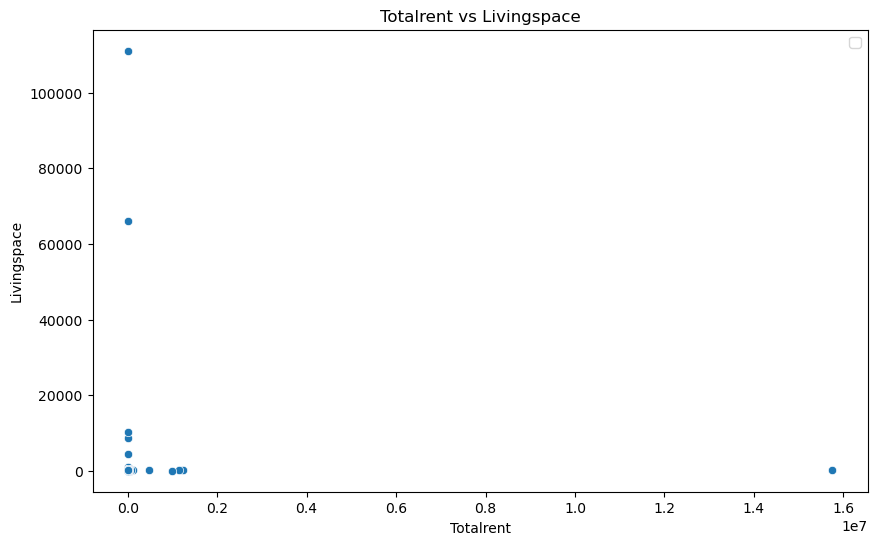

In [ ]:
# Step 5: Bivariate Analysis

# Analyzing the Relationship Between Two Numerical Features
bivariate_analyzer = BivariateAnalyzer(NumericalVsNumericalAnalysis())
bivariate_analyzer.execute_analysis(df_filtered, 'totalRent', 'livingSpace')

/var/folders/nb/6w74_fgn0n95rtjl6646rygh0000gn/T/ipykernel_3436/883534642.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


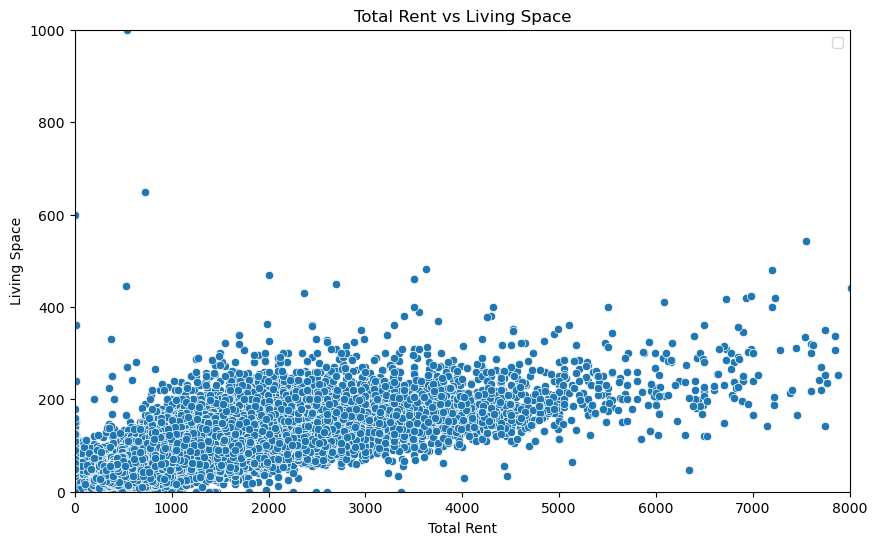

In [17]:
# Removing the outliers for TotalRent and LivingSpace by manually limiting the x and y range
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="totalRent", y="livingSpace")
plt.title("Total Rent vs Living Space")
plt.xlim(0,8000)
plt.ylim(0, 1000)
plt.xlabel("Total Rent")
plt.ylabel("Living Space")
plt.legend()

/Users/aseemshrivastava/Documents/Coding/Project Repositories/germany_apartment_rent_prediction/analysis/analysis_src/bivariate_analysis.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


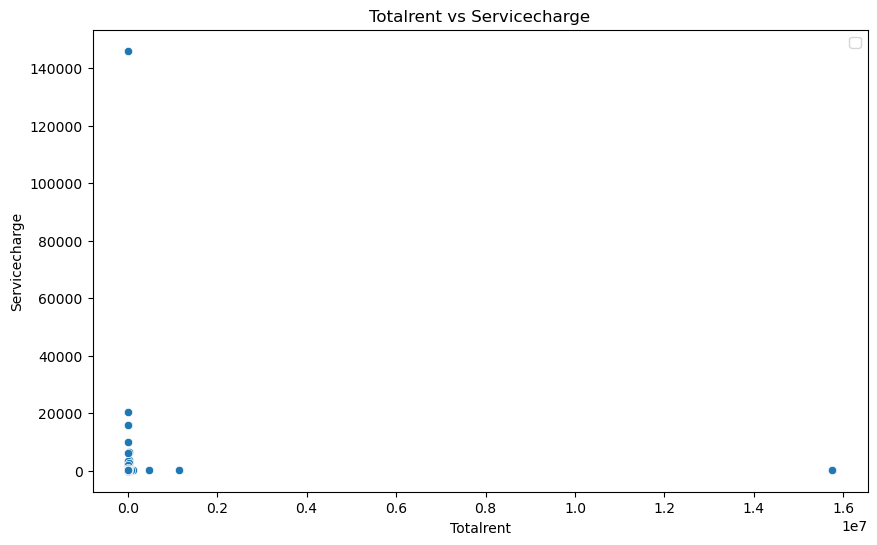

In [18]:
# Analyzing the Relationship Between Two Numerical Features

bivariate_analyzer.execute_analysis(df_filtered, 'totalRent', 'serviceCharge')

/var/folders/nb/6w74_fgn0n95rtjl6646rygh0000gn/T/ipykernel_3436/3092454596.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


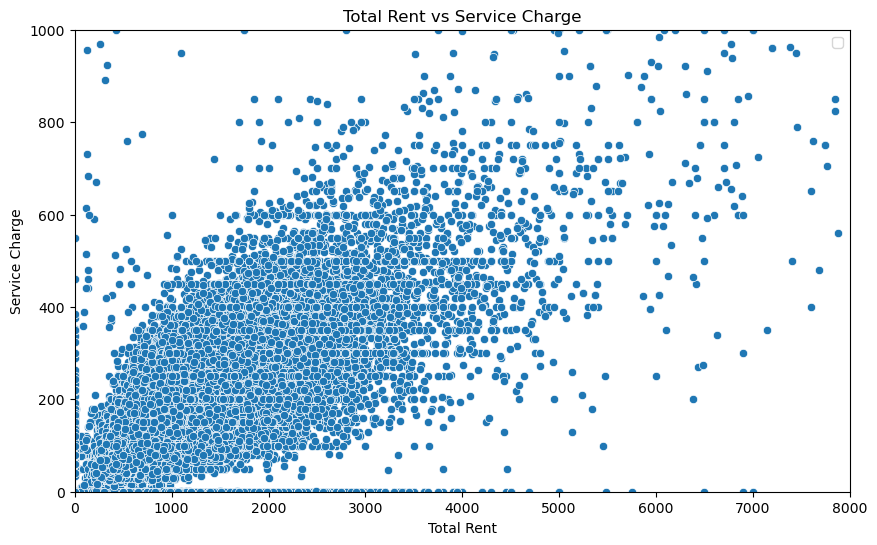

In [24]:
# Removing the outliers for TotalRent and ServiceCharge by manually limiting the x and y range

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x="totalRent", y="serviceCharge")
plt.title("Total Rent vs Service Charge")
plt.xlim(0,8000)
plt.ylim(0, 1000)
plt.xlabel("Total Rent")
plt.ylabel("Service Charge")
plt.legend()

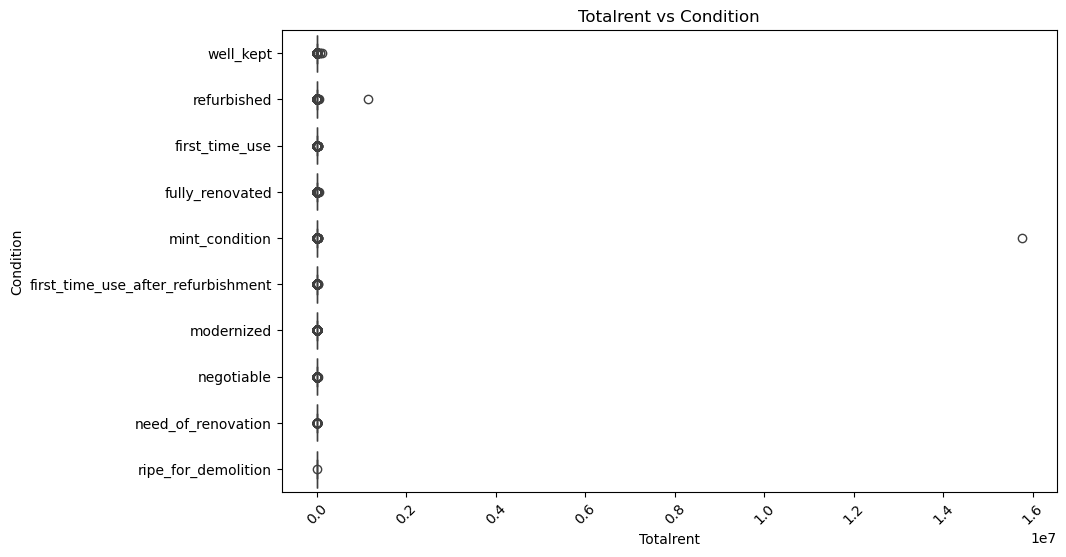

In [20]:
# Analyzing the Relationship Between a Categorical and a Numerical Feature
bivariate_analyzer.set_strategy(CategoricalVsNumericalAnalysis())
bivariate_analyzer.execute_analysis(df_filtered, 'totalRent', 'condition')

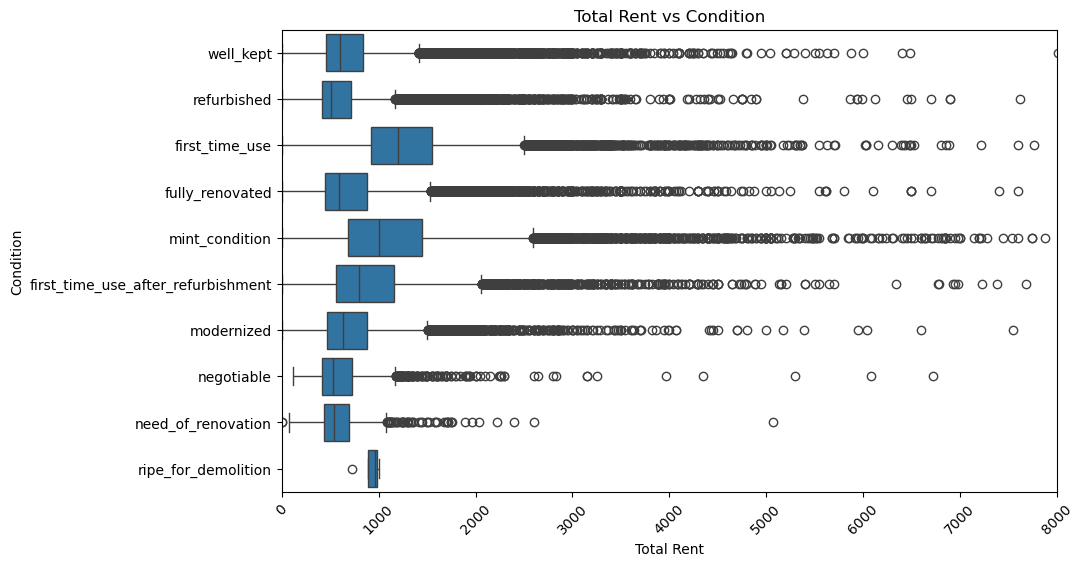

In [21]:
# Removing the outliers for TotalRent by manually limiting the x range

plt.figure(figsize=(10, 6))
sns.boxplot(x="totalRent", y="condition", data=df_filtered)
plt.title("Total Rent vs Condition")
plt.xlim(0, 8000)
plt.xlabel("Total Rent")
plt.ylabel("Condition")
plt.xticks(rotation=45)
plt.show()

## Insights from Multivariate Analysis

#### **Correlation Heatmap**
- Most numerical features in the dataset do not appear to be correlated.
- Highest corelation was observed between `yearConstructed` and `yearConstructedRange`. The feature `yearConstructed` can be removed given the `yearConstructedRange` bins the entries into larger groups that would be helpful for data modeling.

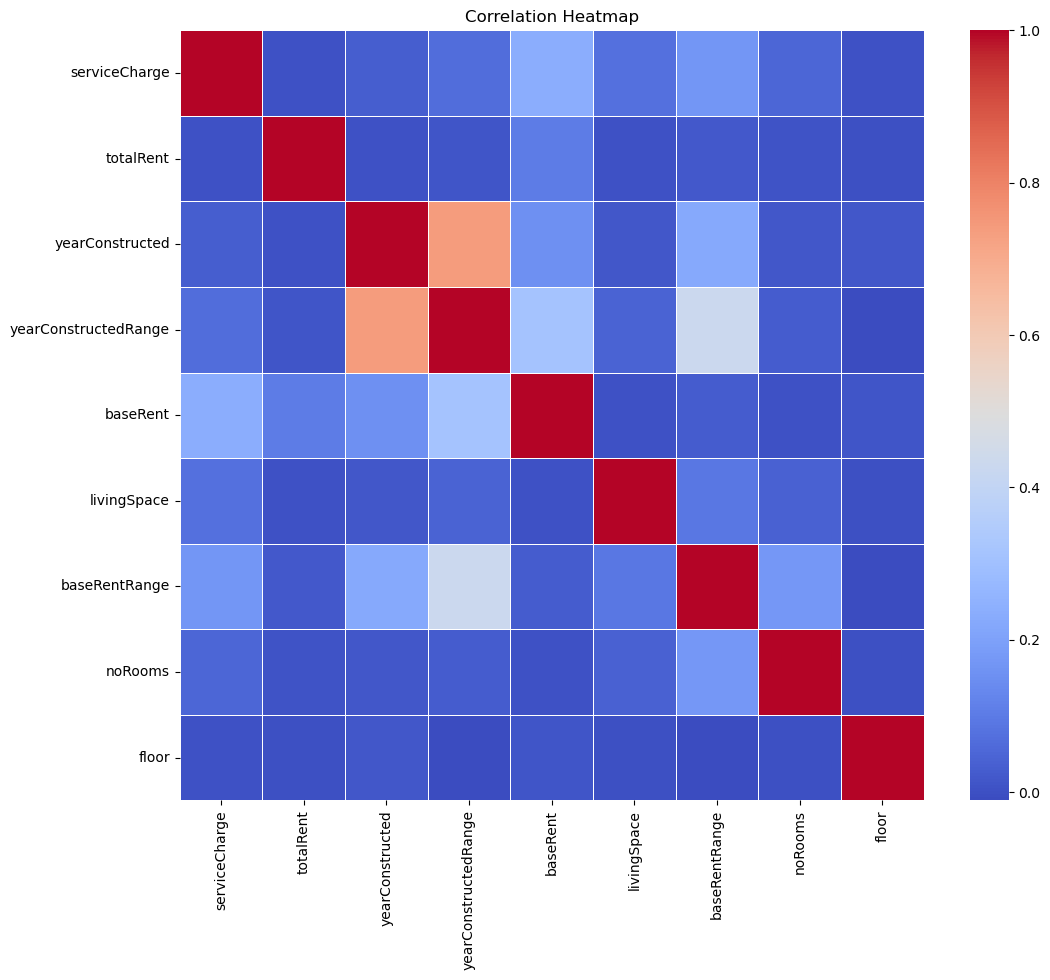

In [ ]:
# Step 6: Multivariate Analysis

multivariate_analyzer = SimpleMultivariateAnalysis()

# Important features for the analysis
df_filtered_numeric = df_filtered.select_dtypes(exclude=['object', "bool"])

multivariate_analyzer.generate_correlation_heatmap(df_filtered_numeric)


## **Issues to be Addressed for Creating Machine Learning Stroke Prediction Model**

1. **Outlier Detection and Handling:**
   - Features like `totalRent`, `yearConstructed` and `livingSpace` show a significant range, indicating potential outliers. These will need to be detected and handled using statistical methods (e.g., Z-scores or IQR) or domain knowledge to avoid skewing model predictions.

2. **Handling Missing Data:**
   - Multiple features have >30% missing values. These **features can be removed**, while those with less missing value frequency can be **imputed using mean, median, or predictive models (e.g., k-NN imputation)**.

3. **Feature Scaling:**
   - Numerical features like `yearConstructed`, `livingSpace`, and `serviceCharge` have different ranges. These need to be normalized (e.g., MinMAxScaler) or standardized (e.g., StandardScaler) to ensure features are on comparable scales for algorithms sensitive to feature magnitudes (e.g., SVM, KNN, logistic regression)

4. **Categorical Encoding:**
   - Categorical features like `heatingType`, `firingTypes`, `condition` and `balcony` are not yet numeric and need to transformed using one-hot encoding.

5. **Feature Engineering:**
   - Columns like `scoutid`, `date` have no predictive value and should be dropped.
   - Based on the insights, certain features might need to be engineered (e.g., combining related features or creating interaction terms) to better capture the relationships in the data.